In [32]:
%pip install -r ../requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# # Machine Learning
# import joblib
# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import (f1_score, precision_score, recall_score, accuracy_score, 
#                            roc_auc_score, roc_curve, confusion_matrix, classification_report)
# from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline

In [34]:
# Import necessary libraries
import sys
import os
import shutil
import joblib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))

# Import project-specific internal modules
from preprocessor import DataPreprocessor
from src.plots import PlotGenerator
from src import config
from config import RUN_CONFIGURATION, EMOTION_STATES, NLP_CONFIG, SENTIMENT_MODEL_EXPORT_PATH_RAW, \
    SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, EMOTION_VARIATIONS_PATH, NEGATION_PATTERNS_PATH, \
    HYPERPARAMETERS, RANDOM_STATE, PREDICTION_MODEL_EXPORT_PATH, TOPIC_MODEL_EXPORT_PATH, \
    is_step_enabled

# Unsupervised learning imports
from clustering import ClusteringAnalysis

# Supervised learning imports

# NLP imports
from src.sentiment_analysis import SentimentAnalysisModel
from src.emotion_postprocessor import EmotionPostProcessor
from src.clinical_notes_prediction import ClinicalNotesNoShowPredictor
from clinical_topic_model import ClinicalTopicModel

sns.set(style='whitegrid')
warnings.filterwarnings("ignore")
plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Create an instance of the preprocessing and plotting classes
preprocessor = DataPreprocessor(config)
plotter = PlotGenerator(style='whitegrid', palette='viridis', figsize=(10, 6))

<a id='dataset'></a>
# 3. Dataset:
---

In [35]:
if is_step_enabled('dataload'):
    df = preprocessor.load_data(config.DATASET_PATH)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

'shape:'

(110527, 17)

'columns:'

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a..."
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ..."
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ..."
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...


,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


<a id='datacleaning'></a>
# 4. Data Cleaning and Pre-processing:
---

In [36]:
if is_step_enabled('data_preprocess'):
    df = preprocessor.preprocess_data(df)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

[preprocessing] Starting preprocessing...
Initial shape of the dataset: (110527, 17)
Initial columns in the dataset: Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')
Dropping unnecessary columns...
Remaining columns: Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason'],
      dtype='object')
Converting date columns to datetime...
Handling missing values...
Adding emotional state columns...
Handling missing values...
Adding emotional state columns...
Emotional state columns added: ['anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Final shape of the datas

'shape:'

(110527, 21)

'columns:'

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason', 'WaitDays', 'anxiety', 'stress', 'confusion', 'hopeful',
       'fear'],
      dtype='object')

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason,WaitDays,anxiety,stress,confusion,hopeful,fear
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,0,0,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a...",-1,0,1,1,0,1
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,0,0,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ...",-1,0,1,1,0,0
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,0,0,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ...",-1,1,0,1,0,0
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,0,0,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...,-1,0,0,0,0,0
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,0,0,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...,-1,0,0,0,0,1


,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays,anxiety,stress,confusion,hopeful,fear
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.183702,0.491979,0.603273,0.532594,0.106336,0.426412
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996,0.499938,0.489221,0.498939,0.308269,0.494557
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id='exploratory'></a>
# 5. Exploratory Data Analysis:
---

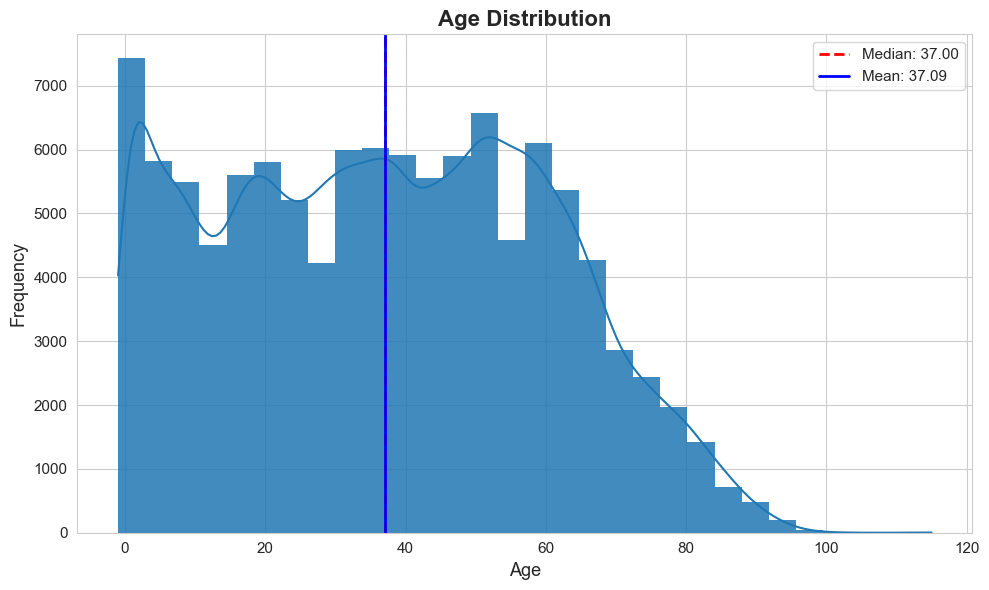

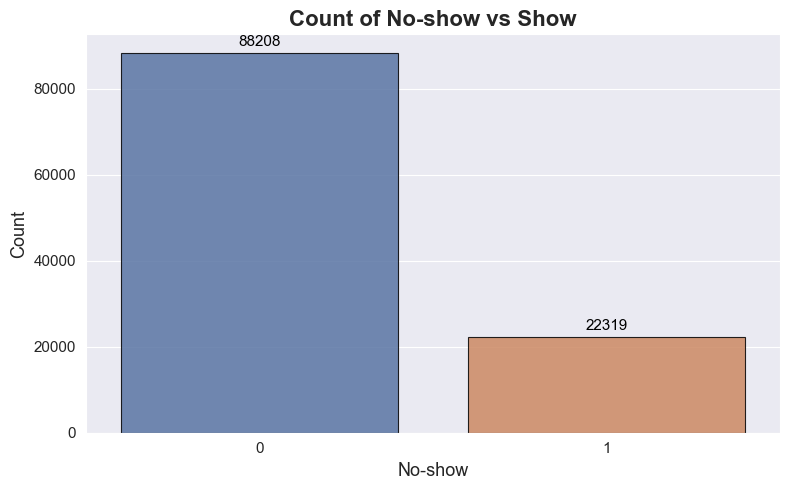

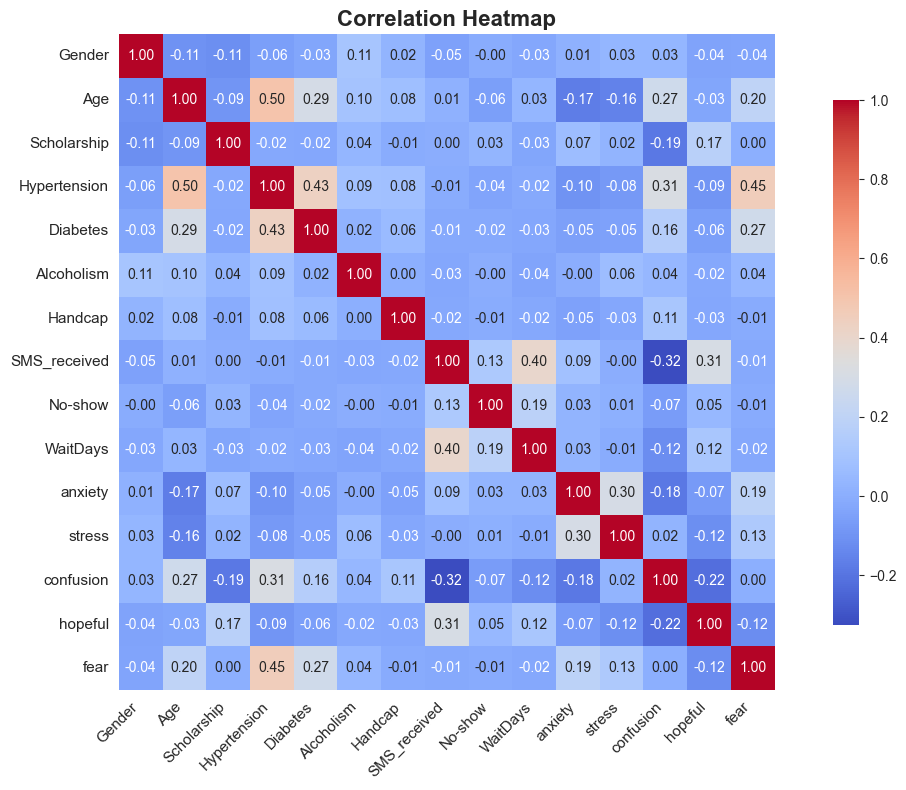

In [37]:
if is_step_enabled('eda'):
    # Distribution of Age - Using class-based approach
    plotter.plot_histplot(
        data=df,
        column='Age',
        bins=30,
        kde=True,
        title='Age Distribution',
        xlabel='Age',
        ylabel='Frequency',
        figsize=(10, 6)
    )

    # Countplot of No-show vs Show
    plotter.plot_countplot(
        data=df,
        column='No-show',
        title='Count of No-show vs Show',
        xlabel='No-show',
        ylabel='Count',
        figsize=(8, 5)
    )

    # Correlation heatmap 
    numeric_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()
    plotter.plot_heatmap(
        data=correlation_matrix,
        title='Correlation Heatmap',
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        figsize=(12, 8)
    )

- The age distribution peaks in early childhood and declines steadily with age, showing most patients are under 60.
- The distribution is fairly symmetric with a slight right skew due to fewer older patients.
- The plot shows that most patients attended their appointments (No-show=0), while a smaller group missed them (No-show=1).
- This indicates a class imbalance, which is important to consider for predictive modeling.
- The correlation heatmap shows weak to moderate relationships among most features, with few strong correlations (e.g., Age-Hypertension, Hypertension-Diabetes).
- Most variables are largely independent, suggesting minimal multicollinearity and diverse feature contributions for modeling.

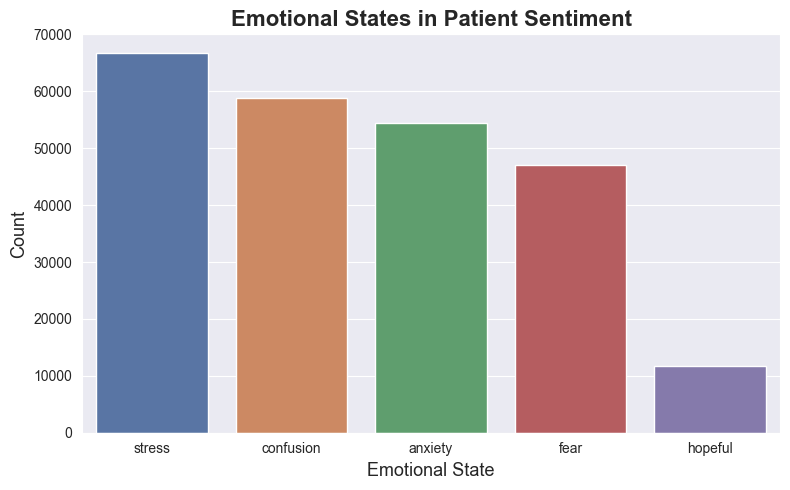

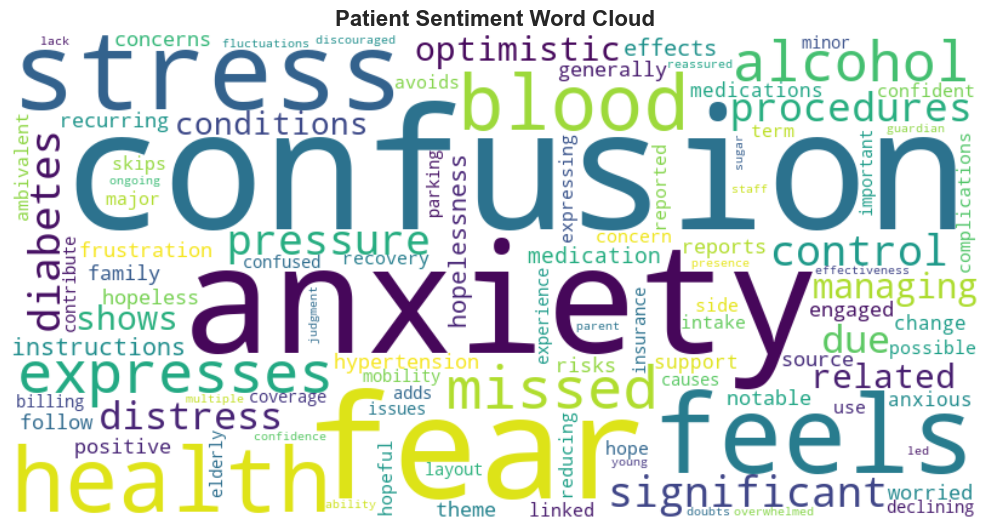

Total unique words after filtering: 161
Top 10 most frequent words: {'confusion': 77779, 'anxiety': 62099, 'fear': 57339, 'stress': 55610, 'feels': 54774, 'health': 50047, 'blood': 35628, 'expresses': 34563, 'missed': 33931, 'alcohol': 29663}


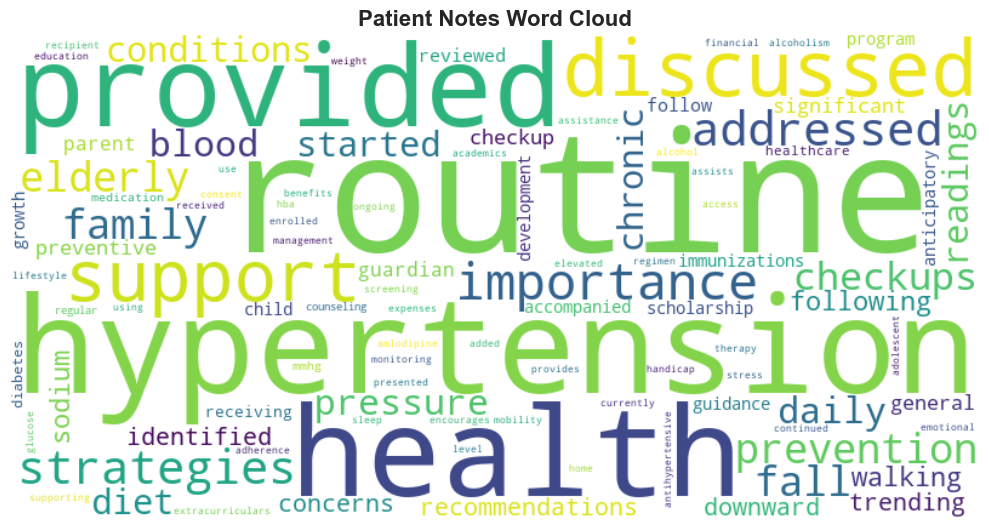

Total unique words after filtering: 480
Top 10 most frequent words: {'routine': 75106, 'hypertension': 69899, 'health': 62876, 'provided': 61365, 'discussed': 56894, 'support': 54154, 'importance': 45468, 'strategies': 43443, 'addressed': 43435, 'prevention': 43424}


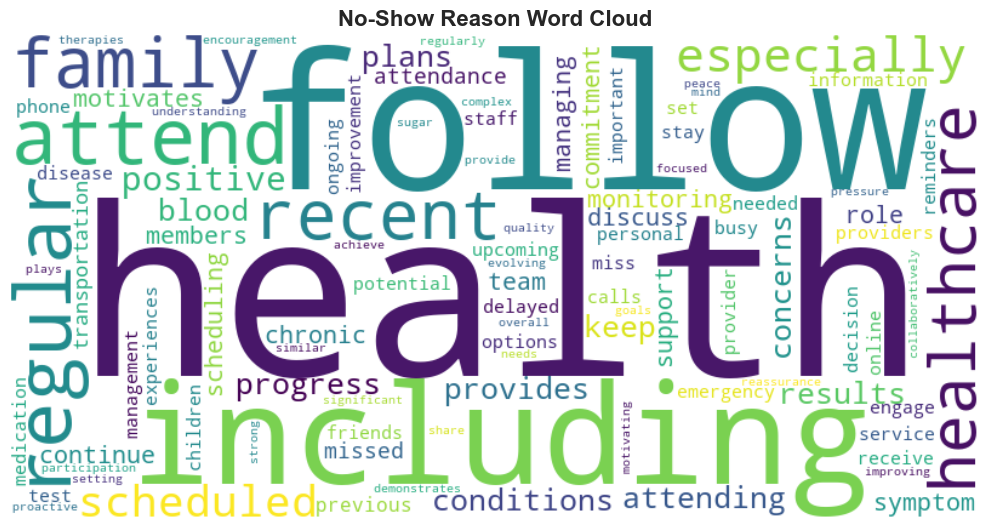

Total unique words after filtering: 477
Top 10 most frequent words: {'health': 35477, 'follow': 21074, 'including': 19948, 'attend': 15422, 'regular': 15302, 'family': 13660, 'recent': 13186, 'healthcare': 11945, 'especially': 11621, 'scheduled': 11592}


In [38]:
if is_step_enabled('eda'):
    # Plot emotional states as a bar plot - Using class method
    plotter.plot_emotional_states_bar(df)

    # Plot word clouds for PatientSentiment, PatientNotes, and NoShowReason
    plotter.plot_text_wordcloud_custom_stopwords(df['PatientSentiment'], title='Patient Sentiment Word Cloud')
    plotter.plot_text_wordcloud_custom_stopwords(df['PatientNotes'], title='Patient Notes Word Cloud')
    plotter.plot_text_wordcloud_custom_stopwords(df['NoShowReason'], title='No-Show Reason Word Cloud')

- The bar plot shows that stress, confusion, and anxiety are the most common emotional states among patients, with stress being the highest.
- Hopeful sentiment is much less frequent, indicating a predominance of negative emotions in patient sentiment data.
- The word cloud highlights that "confusion," "anxiety," "fear," and "stress" are the most frequently expressed sentiments among patients. This suggests that negative emotions dominate patient feedback, indicating areas for targeted intervention.
- The word cloud shows that "routine", "hypertension", "health", and "provided" are the most frequently mentioned terms in patient notes, highlighting a focus on regular care and chronic condition management.
- The word cloud shows that "health", "follow", "attend", and "including" are the most common reasons cited for no-shows, highlighting the importance of health-related factors and follow-up in patient attendance.

<a id='modelselection'></a>
# 6. Model Selection:
---

This project employs a combination of supervised, unsupervised, and natural language processing (NLP) models to predict and analyze patient appointment no-shows. 

### Supervised Learning Models

**Logistic Regression**  
Logistic Regression is a statistical model used for binary classification tasks. It estimates the probability that a given input belongs to a particular category by applying the logistic (sigmoid) function to a linear combination of input features (Hosmer et al., 2013).  
*Justification:* Logistic Regression is interpretable and effective for baseline binary classification, making it suitable for predicting no-show events based on structured patient data.

**Random Forest**  
Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of their predictions (Breiman, 2001). It handles non-linear relationships and interactions between features well.  
*Justification:* Random Forest is robust to overfitting and can capture complex patterns in the data, which is valuable for healthcare datasets with mixed feature types.

**Gradient Boosting (XGBoost)**  
XGBoost is an optimized implementation of gradient boosting machines, which sequentially build decision trees to correct errors made by previous trees (Chen & Guestrin, 2016).  
*Justification:* XGBoost is known for its high predictive performance and efficiency, making it suitable for structured data with potential feature interactions.

### Unsupervised Learning Models

**Principal Component Analysis (PCA)**  
PCA is a dimensionality reduction technique that transforms correlated features into a set of linearly uncorrelated components, capturing the maximum variance in the data (Jolliffe & Cadima, 2016).  
*Justification:* PCA helps visualize and reduce the complexity of high-dimensional patient data, facilitating clustering and interpretation.

**K-Means Clustering**  
K-Means is an unsupervised algorithm that partitions data into k clusters by minimizing the within-cluster sum of squares (MacQueen, 1967).  
*Justification:* K-Means is efficient for grouping patients with similar profiles, aiding in understanding patient segments and tailoring interventions.

**Gaussian Mixture Model (GMM)**  
GMM is a probabilistic model that assumes data is generated from a mixture of several Gaussian distributions (Reynolds, 2009).  
*Justification:* GMM provides soft clustering and can model clusters of different shapes and sizes, which is useful for heterogeneous patient populations.

### Natural Language Processing (NLP) Models

**Sentiment Analysis Model**  
A custom neural network-based sentiment analysis model is used to detect emotional states in patient notes, leveraging domain-specific vocabularies and context-aware rules (Cambria et al., 2017).  
*Justification:* Understanding patient sentiment provides insights into behavioral factors influencing no-shows, complementing structured data analysis.

**Topic Modeling (LDA with MedSpaCy Preprocessing)**  
Latent Dirichlet Allocation (LDA) is a generative probabilistic model for discovering topics in text corpora (Blei et al., 2003). MedSpaCy is used for clinical concept extraction and preprocessing.  
*Justification:* Topic modeling uncovers underlying themes and reasons for no-shows in clinical notes, supporting qualitative analysis.

<a id='modelselectionsupervised'></a>
## 6.1 Supervised Learning - Patient Show/No Show Prediction:
---

This use case focuses exclusively on **Supervised Learning for Patient Show/No Show Prediction**. Missed medical appointments, or "no-shows," can disrupt healthcare operations and negatively impact patient outcomes. To address this, the project leverages supervised machine learning models to predict whether a patient will attend their scheduled appointment.

**Algorithm and Approach:**
- **Supervised Learning Models:** Logistic Regression, Random Forest, and XGBoost are employed to predict appointment attendance using structured data such as demographics, medical history, and appointment details.
- **Feature Engineering:** Relevant features are selected and engineered to improve model performance, including patient age, prior no-show history, comorbidities, and appointment lead time.
- **Model Evaluation:** The models are evaluated using metrics like accuracy, precision, recall, and ROC-AUC to ensure reliable predictions.

By accurately identifying patients at risk of missing appointments, this approach enables healthcare providers to implement targeted interventions, optimize scheduling, and improve overall patient care.

<a id='logisticregression'></a>
### 6.1.1 Logistic Regression:
---

<a id='randomforest'></a>
### 6.1.2 Random Forest:
---

<a id='xgboost'></a>
### 6.1.3 Gradient Boosting-XGBoost:
---

<a id='supervisedfeature'></a>
### 6.1.4 Feature Engineering:
---

In [39]:
# Feature selection for modeling
selected_features = [
    'WaitDays', 'SMS_received', 'Age', 'Alcoholism', 
    'Scholarship', 'Gender', 'Diabetes', 'Handcap'
]

X = df[selected_features].copy()
y = df['No-show']

print(f"\nFeatures shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"No-show rate: {y.mean():.1%}")


Features shape: (110527, 8)
Target distribution: {0: 88208, 1: 22319}
No-show rate: 20.2%


<a id='supervisedtraining'></a>
### 6.1.5 Model Training:
---

In [40]:
from src.no_show_prediction import NoShowPredictionModel

# Feature selection for modeling
selected_features = [
    'WaitDays', 'SMS_received', 'Age', 'Alcoholism', 
    'Scholarship', 'Gender', 'Diabetes', 'Handcap'
]

# Initialize model
no_show_model = NoShowPredictionModel(df, selected_features, 'No-show', plotter=plotter)

# Split data
no_show_model.split_data()

# Analyze class imbalance
class_distribution, class_weight_dict, scale_pos_weight = no_show_model.analyze_class_imbalance()
print("CLASS IMBALANCE ANALYSIS")
print("=" * 40)
print(f"Training samples: {len(no_show_model.X_train):,}")
print(f"Test samples: {len(no_show_model.X_test):,}")
print(f"No-show rate: {class_distribution[1]:.1%}")
class_ratio = (no_show_model.y_train == 0).sum() / (no_show_model.y_train == 1).sum()
print(f"Class ratio (Show:No-show): {class_ratio:.1f}:1")
print(f"Imbalance severity: {'High' if class_ratio > 3 else 'Moderate'}")
print(f"\nClass weights: {class_weight_dict}")
print(f"XGBoost scale_pos_weight: {scale_pos_weight:.2f}")

CLASS IMBALANCE ANALYSIS
Training samples: 88,421
Test samples: 22,106
No-show rate: 20.2%
Class ratio (Show:No-show): 4.0:1
Imbalance severity: High

Class weights: {0: 0.6265127681886461, 1: 2.4760851302156257}
XGBoost scale_pos_weight: 0.25


In [41]:
# Train baseline models
base_summary = no_show_model.train_baseline_models()
display(base_summary.round(3))


,F1,Precision,Recall,Accuracy,ROC_AUC
Logistic Regression,0.411,0.321,0.572,0.669,0.669
Random Forest,0.361,0.311,0.430,0.693,0.635
XGBoost,0.003,0.857,0.001,0.798,0.728


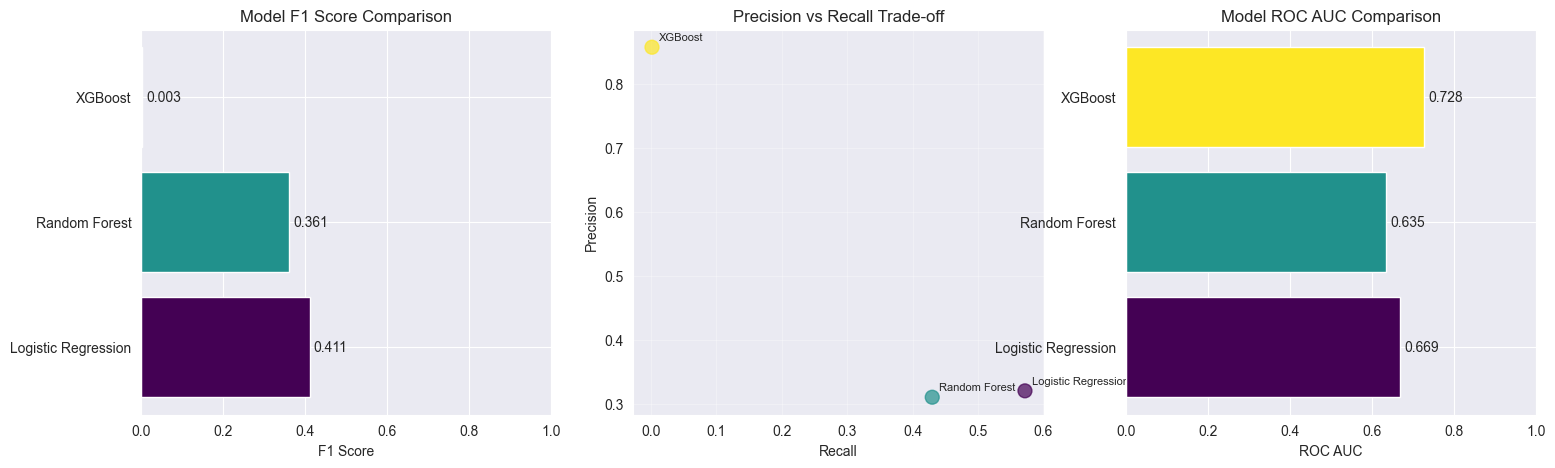

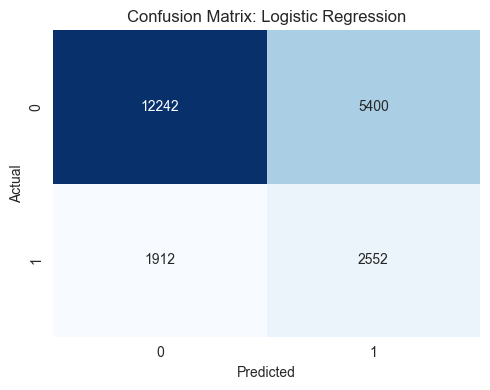

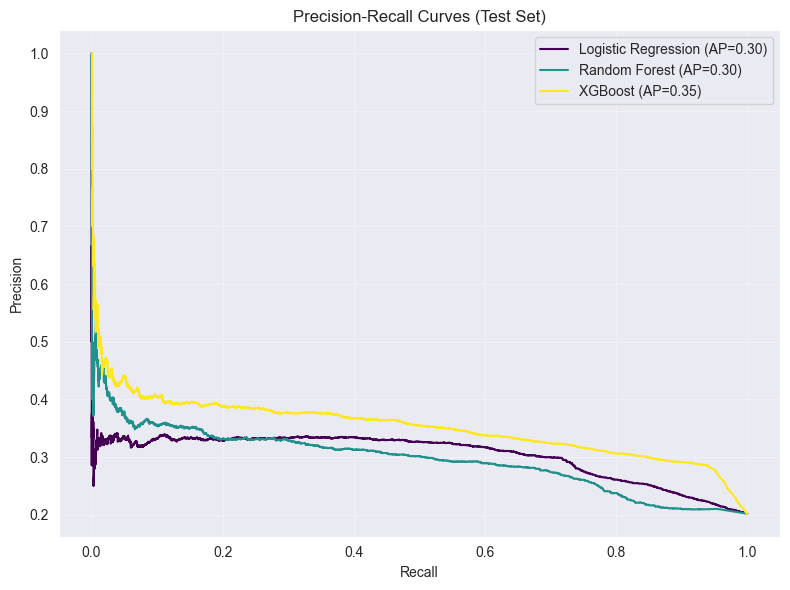

<Figure size 640x480 with 0 Axes>

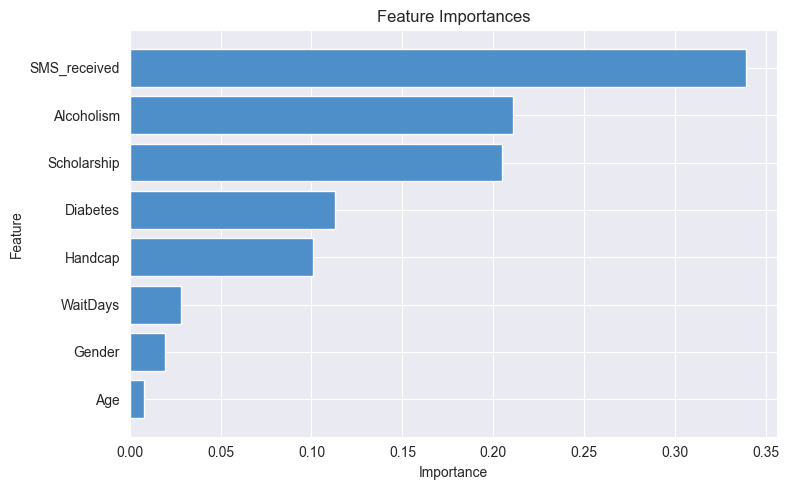

In [42]:
# Plot baseline model performance (F1, Precision, Accuracy, ROC_AUC) and confusion matrix
plotter.plot_prediction_model_performance(
    base_summary,
    show_tuning_impact=False,
    X_test=no_show_model.X_test,
    y_test=no_show_model.y_test,
    models_dict=no_show_model.base_models
)

# Plot feature importances for the best baseline model
best_base_model_name = base_summary.index[0]
best_base_model = no_show_model.base_models[best_base_model_name]
plotter.plot_prediction_feature_importances(best_base_model, no_show_model.features)

<a id='supervisedhyper'></a>
### 6.1.6 Hyper Parameter Tuning:
---

In [43]:
# HYPERPARAMETERS = {
#     'logistic_regression': {
#         'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 20],
#         'solver': ['liblinear', 'lbfgs'],
#         'penalty': ['l1', 'l2'],
#         'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}],
#         'max_iter': [1000, 2000]
#     },
#     'lr_n_iter': 20,
#     'random_forest': {
#         'bootstrap': [True, False],
#         'n_estimators': [100, 200, 300],
#         'max_depth': [3, 5, 7, 10, None],
#         'min_samples_split': [2, 5, 10, 20],
#         'min_samples_leaf': [1, 2, 4, 8],
#         'max_features': ['sqrt', 'log2', 0.5, 0.7],
#         'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 2}, {0: 1, 1: 3}]
#     },
#     'rf_n_iter': 20,
#     'xgboost': {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [3, 4, 5, 6],
#         'learning_rate': [0.01, 0.05, 0.1, 0.15],
#         'subsample': [0.7, 0.8, 0.9, 1.0],
#         'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
#         'reg_alpha': [0, 0.01, 0.1],
#         'reg_lambda': [0.5, 1, 1.5],
#         'gamma': [0, 0.1, 0.5]
#     },
#     'xgb_n_iter': 20
# }

lr_random, rf_random, xgb_fine = no_show_model.tune_hyperparameters()
print("Hyperparameter tuning completed.")

# After tuning, evaluate all models again
results_df = no_show_model.evaluate_models()
display(results_df.round(3))

Starting hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Logistic Regression F1: 0.408
Best Logistic Regression params: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000, 'class_weight': {0: 1, 1: 4}, 'C': 0.01}
Starting hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Logistic Regression F1: 0.408
Best Logistic Regression params: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000, 'class_weight': {0: 1, 1: 4}, 'C': 0.01}
Starting hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest F1: 0.444
Best Random Forest params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': 7, 'class_weight': 'balanced_subsample', 'bootstrap': False}
Starting hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 20 candidates, totall

,F1,Precision,Recall,Accuracy,ROC_AUC
Random Forest (Tuned),0.447,0.306,0.825,0.587,0.729
Logistic Regression (Tuned),0.413,0.321,0.580,0.668,0.670
Logistic Regression,0.411,0.321,0.572,0.669,0.669
Random Forest,0.361,0.311,0.430,0.693,0.635
XGBoost (Tuned),0.056,0.451,0.030,0.797,0.728
XGBoost,0.003,0.857,0.001,0.798,0.728


Best Model: Random Forest (Tuned)


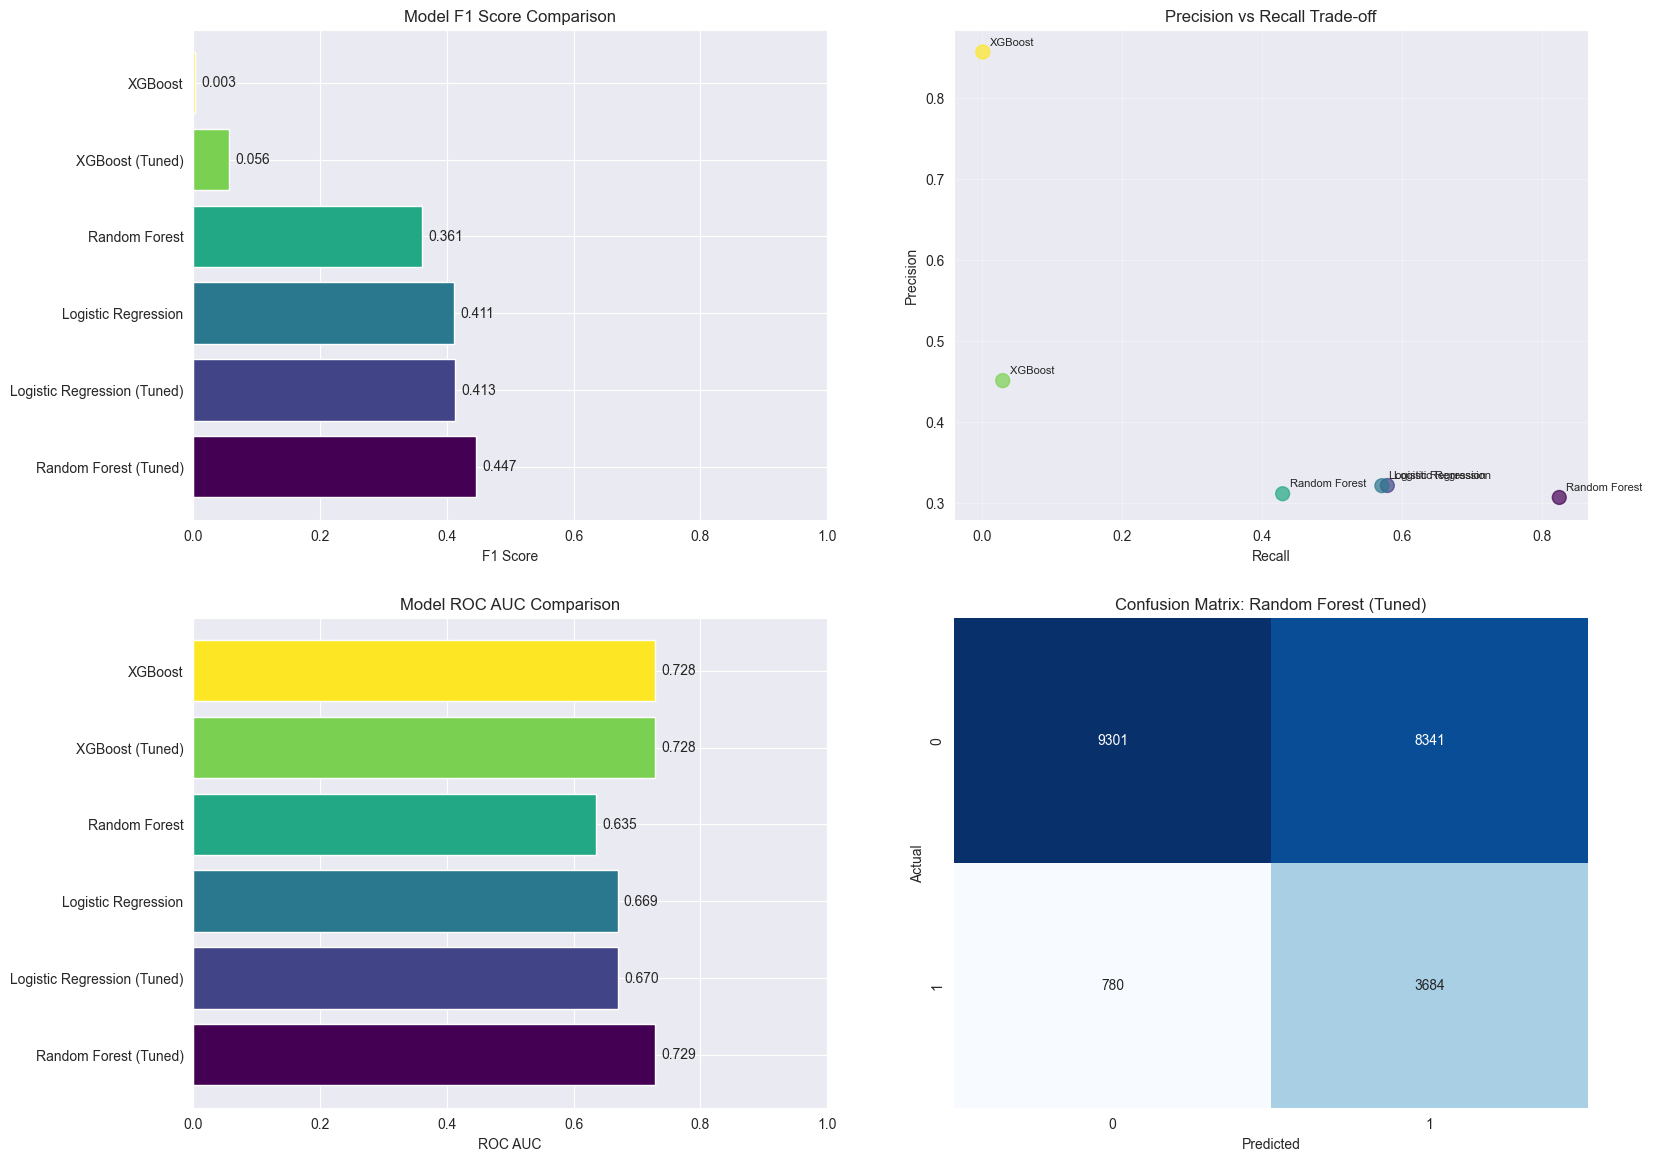

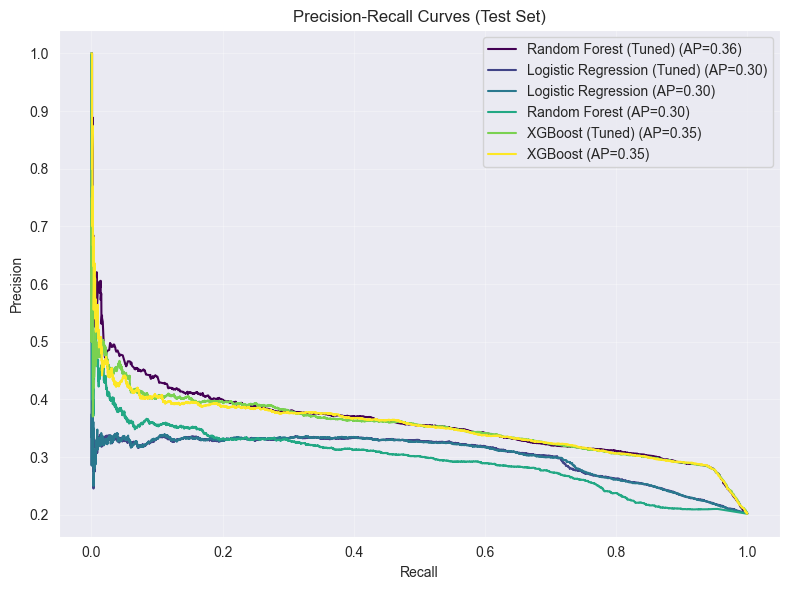

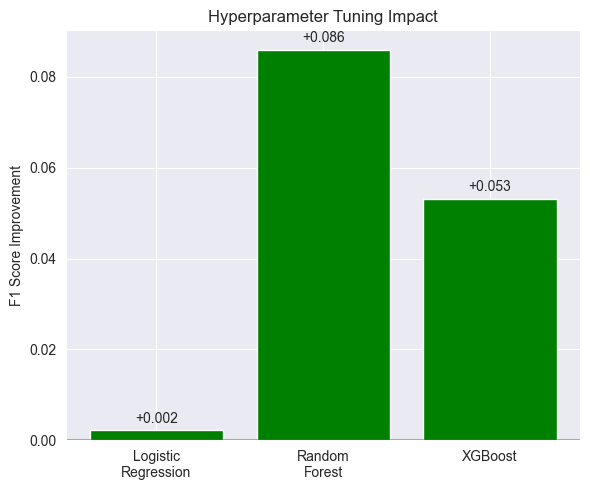

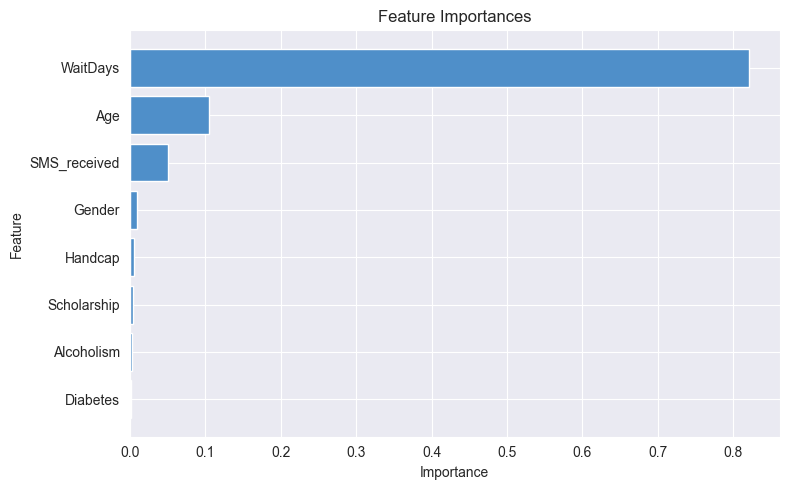

In [45]:
# Evaluate the optimized model
print(f"Best Model: {no_show_model.best_model_name}")

# Plot tuned model performance (F1, Precision, Accuracy, ROC_AUC) and confusion matrix
plotter.plot_prediction_model_performance(
    results_df,
    show_tuning_impact=True,
    X_test=no_show_model.X_test,
    y_test=no_show_model.y_test,
    models_dict={**no_show_model.base_models, **no_show_model.tuned_models}
)

# Plot feature importances for the best model after tuning
best_model = {**no_show_model.base_models, **no_show_model.tuned_models}[no_show_model.best_model_name]
plotter.plot_prediction_feature_importances(best_model, no_show_model.features)

In [46]:
# SMOTE + Threshold Optimization
# Find best performing model from tuning
scores = {
    'LR': lr_random.best_score_,
    'RF': rf_random.best_score_,
    'XGB': xgb_fine.best_score_
}
best_model_type = max(scores, key=scores.get)
if best_model_type == 'XGB':
    best_base_model = xgb_fine.best_estimator_
elif best_model_type == 'RF':
    best_base_model = rf_random.best_estimator_
else:
    best_base_model = lr_random.best_estimator_

optimized_smote_model, threshold_df = no_show_model.smote_threshold_optimization(best_base_model)
print("SMOTE + Threshold optimization completed.")

Starting SMOTE + Threshold Optimization...
Threshold: 0.10 | F1: 0.347 | Precision: 0.210 | Recall: 0.994
Threshold: 0.15 | F1: 0.403 | Precision: 0.255 | Recall: 0.965
Threshold: 0.20 | F1: 0.423 | Precision: 0.272 | Recall: 0.955
Threshold: 0.25 | F1: 0.431 | Precision: 0.279 | Recall: 0.948
Threshold: 0.30 | F1: 0.435 | Precision: 0.283 | Recall: 0.940
Threshold: 0.35 | F1: 0.435 | Precision: 0.284 | Recall: 0.928
Threshold: 0.40 | F1: 0.440 | Precision: 0.291 | Recall: 0.897
Threshold: 0.45 | F1: 0.438 | Precision: 0.294 | Recall: 0.857
Threshold: 0.50 | F1: 0.436 | Precision: 0.296 | Recall: 0.822
Threshold: 0.55 | F1: 0.433 | Precision: 0.313 | Recall: 0.701
Threshold: 0.60 | F1: 0.400 | Precision: 0.330 | Recall: 0.507
Threshold: 0.65 | F1: 0.349 | Precision: 0.350 | Recall: 0.348
Threshold: 0.10 | F1: 0.347 | Precision: 0.210 | Recall: 0.994
Threshold: 0.15 | F1: 0.403 | Precision: 0.255 | Recall: 0.965
Threshold: 0.20 | F1: 0.423 | Precision: 0.272 | Recall: 0.955
Threshold: 0

<a id='supervisedanalysis'></a>
### 6.1.8 Model Analysis:
---

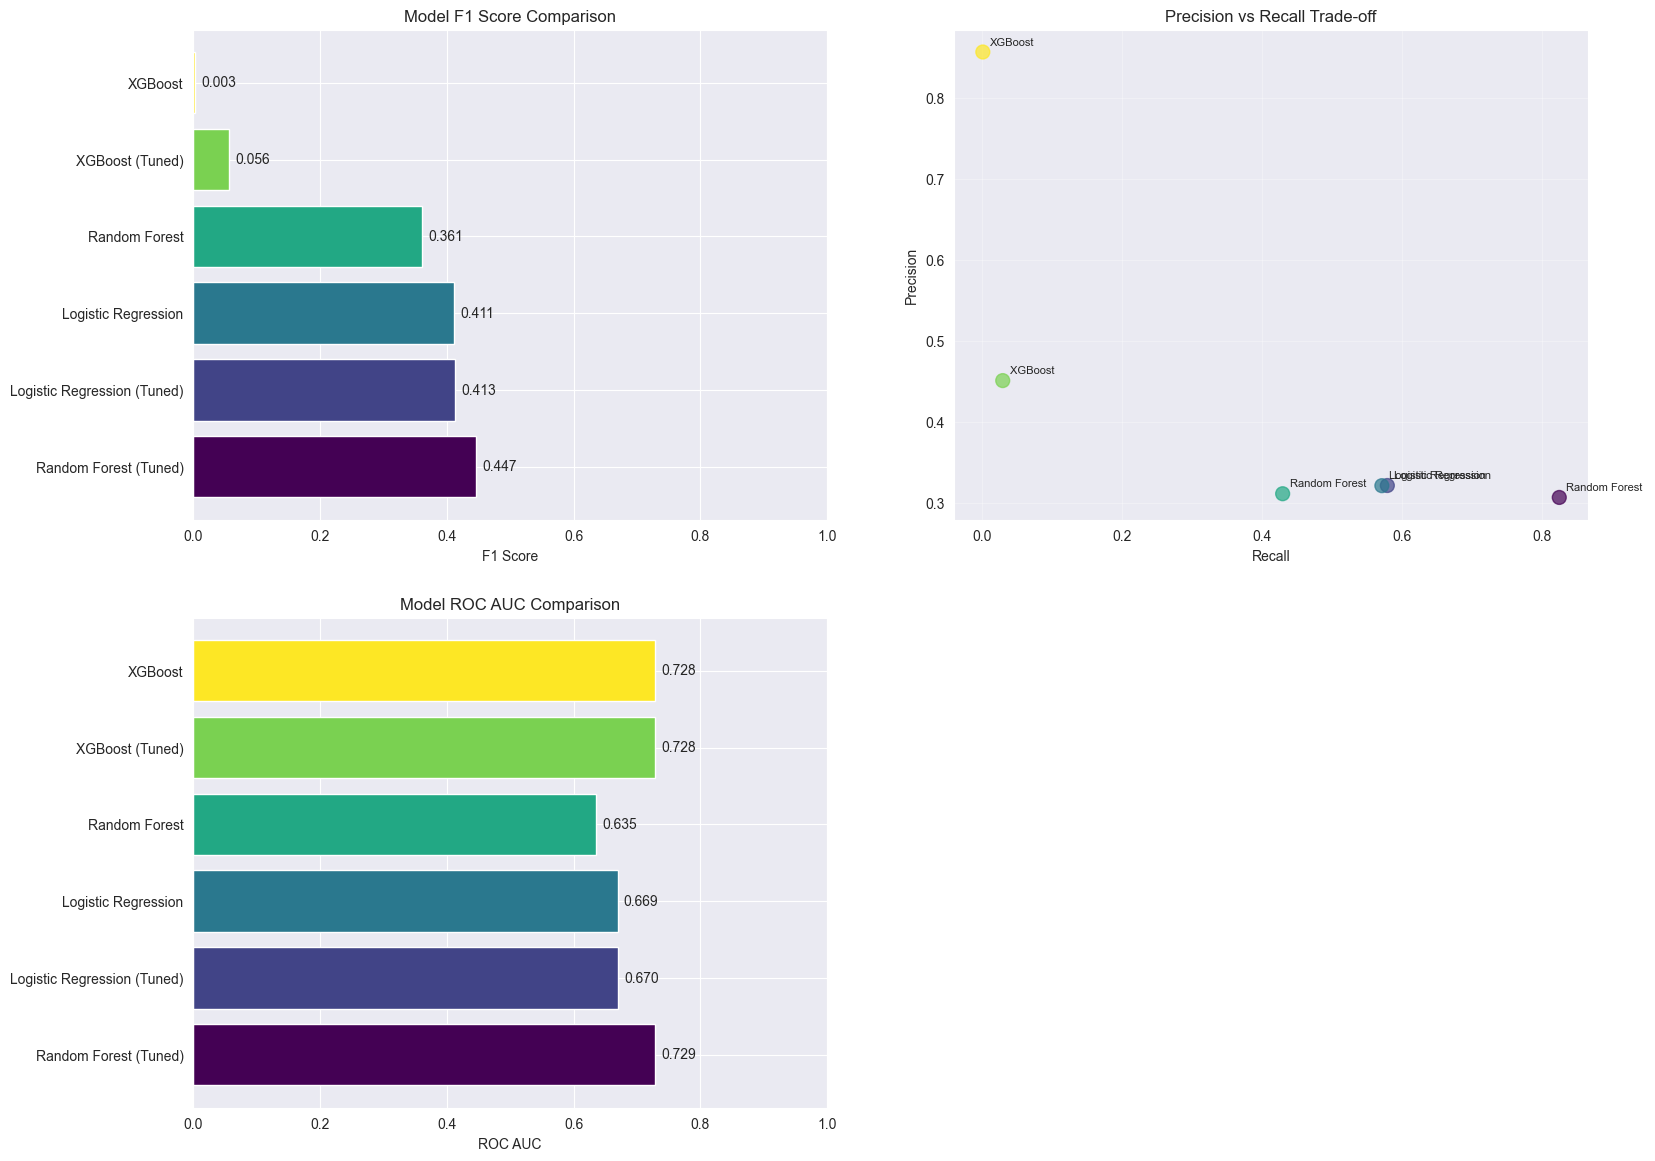

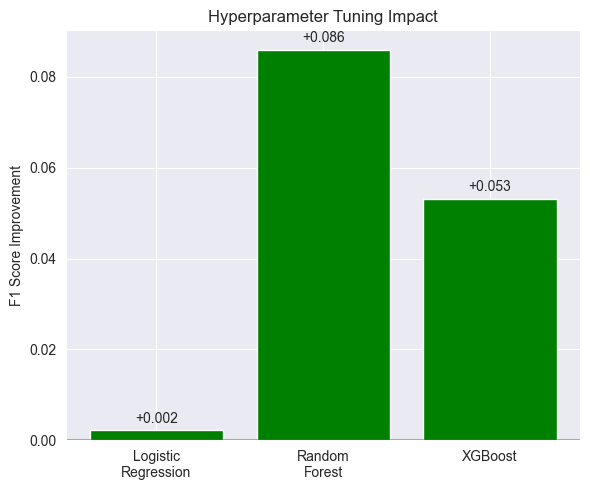

In [47]:
# Performance comparison visualization
no_show_model.plot_performance(show_tuning_impact=True)

In [48]:
metrics = no_show_model.evaluate_model_metrics()
display(metrics)

{'total_patients': 22106,
 'actual_no_shows': 4464,
 'precision': 0.30636174636174635,
 'recall': 0.8252688172043011,
 'f1': 0.446843350112196,
 'predicted_no_shows': 14571,
 'true_positives': 4463,
 'prevented_no_shows': 1115,
 'baseline_cost': 669600,
 'intervention_cost_total': 364275,
 'prevented_cost': 167250,
 'net_benefit': -197025,
 'roi': -54.08688490837966}

In [49]:
# Test predictions on the test set and display a sample
if hasattr(no_show_model, 'X_test') and hasattr(no_show_model, 'y_test') and hasattr(no_show_model, 'best_model'):
    y_pred = no_show_model.best_model.predict(no_show_model.X_test)
    results_df = no_show_model.X_test.copy()
    results_df['Actual'] = no_show_model.y_test.values
    results_df['Predicted'] = y_pred
    display(results_df.head(10))
    print('Prediction test completed. Showing first 10 predictions.')
else:
    print('Test set or best model not available for prediction test.')


,WaitDays,SMS_received,Age,Alcoholism,Scholarship,Gender,Diabetes,Handcap,Actual,Predicted
23937,-1,0,7.0,0,0,1,0,0,1,0
99403,26,1,42.0,0,0,0,0,0,0,1
100162,13,1,3.0,0,1,1,0,0,0,1
63869,4,1,50.0,0,0,1,0,0,1,0
7668,-1,0,59.0,0,1,1,0,0,0,0
45098,-1,0,0.0,0,0,1,0,0,0,0
28787,13,0,37.0,0,0,0,0,0,1,1
25073,-1,0,71.0,0,0,0,1,0,0,0
28854,17,1,44.0,0,0,0,1,2,1,0
24559,3,0,60.0,0,0,0,1,0,0,1


Prediction test completed. Showing first 10 predictions.


In [50]:
# Export the best model
if hasattr(no_show_model, 'best_model'):
    export_path = config.PREDICTION_MODEL_EXPORT_PATH
    # If export_path is a directory, append a filename
    if os.path.isdir(export_path):
        export_path = os.path.join(export_path, "best_model.pkl")
    else:
        # If the parent directory does not exist, create it
        parent_dir = os.path.dirname(export_path)
        if parent_dir and not os.path.exists(parent_dir):
            os.makedirs(parent_dir, exist_ok=True)
        if export_path and not os.path.exists(export_path):
            os.makedirs(export_path, exist_ok=True)
            export_path = os.path.join(export_path, "best_model.pkl")
    joblib.dump(no_show_model.best_model, export_path)
    print(f'Best model exported to: {export_path}')
else:
    print('No best model found to export.')

Best model exported to: d:\Personal\AI-Admissions\Semester 3\AAI-510 - Machine learning Fundamentals and Applications\Final Team Project\aai510_3proj\models\supervised\prediction\best_model.pkl


<a id='supervisedconclusion'></a>
### 6.1.7 Conclusion:
---